In [28]:
import os, json
from collections import defaultdict
import pandas as pd


In [29]:
#collect all JSON files in the current directory
json_files = [f for f in os.listdir('.') if f.endswith('.json')]

In [ ]:
# --- Catalog-based classification using tech_classification.json ---
import json, re
from pathlib import Path

CATALOG_PATH = Path("classification/tech_classification.json")

def _normalize_term(s: str) -> str:
    if not isinstance(s, str):
        return ""
    # lower, trim, replace hyphens/underscores with space, collapse spaces
    s = s.strip().lower()
    s = s.replace("_", " ").replace("-", " ")
    s = re.sub(r"\s+", " ", s)
    return s

def _load_catalog(path=CATALOG_PATH):
    with open(path, "r", encoding="utf-8") as f:
        raw = json.load(f)
    # Build exact map and a list for substring matching (prefer longest terms)
    exact_map = {}
    keyword_list = []
    for cat, terms in raw.items():
        for t in terms:
            nt = _normalize_term(t)
            if not nt:
                continue
            # first-write wins; if duplicates across categories, keep earliest encountered
            if nt not in exact_map:
                exact_map[nt] = cat
                keyword_list.append(nt)
    keyword_list = sorted(set(keyword_list), key=len, reverse=True)
    return raw, exact_map, keyword_list

CATALOG_RAW, CATALOG_EXACT_MAP, CATALOG_KEYWORDS = _load_catalog()

def classify_technology(term: str) -> str:
    """
    Classify a technology using the catalog json first, then fall back to previous keyword classifier.
    Order:
      1) exact normalized match against catalog
      2) plural handling (strip trailing 's') and whitespace/spacing normalization
      3) substring match against catalog terms (longest first)
      4) fallback: classify_term_improved
      5) 'Other / N/A'
    """
    if not isinstance(term, str) or term.strip() == "":
        return "Other / N/A"
    norm = _normalize_term(term)

    # exact match
    if norm in CATALOG_EXACT_MAP:
        return CATALOG_EXACT_MAP[norm]

    # simple plural strip
    if norm.endswith("s") and norm[:-1] in CATALOG_EXACT_MAP:
        return CATALOG_EXACT_MAP[norm[:-1]]

    # substring match, prefer longest catalog phrase
    for kw in CATALOG_KEYWORDS:
        if kw in norm:
            return CATALOG_EXACT_MAP[kw]

    # fallback to previous improved keyword logic if available
    try:
        return classify_term_improved(term)
    except NameError:
        return "Other / N/A"

# --- Preview: categorize technologies with the catalog classifier ---
# Ensure 'terms' exists: prefer eda_df from downstream cell; otherwise build from json_files.
try:
    terms  # type: ignore  # noqa: F821
except NameError:
    if "eda_df" in globals():
        terms = [str(t) for t in eda_df["technology_name"].dropna().unique().tolist()]
    else:
        # Fallback: extract technology_name from JSON files listed in json_files
        terms = []
        file_list = json_files if "json_files" in globals() else []
        for fp in file_list:
            try:
                with open(fp, "r", encoding="utf-8") as f:
                    data = json.load(f)
            except Exception:
                continue
            records = data if isinstance(data, list) else [data] if isinstance(data, dict) else []
            for rec in records:
                if not isinstance(rec, dict):
                    continue
                tech_list = rec.get("technologies") or []
                if isinstance(tech_list, dict):
                    tech_list = [tech_list]
                for tech in tech_list:
                    if not isinstance(tech, dict):
                        continue
                    tname = tech.get("technology_name")
                    if isinstance(tname, str) and tname.strip():
                        terms.append(tname)
        # unique and sorted for stable output
        terms = sorted(set(terms))

grouped_catalog = defaultdict(list)
for t in terms:
    grouped_catalog[classify_technology(t)].append(t)

grouped_catalog = dict(grouped_catalog)

# Coverage diagnostics
total_terms = len(terms)
matched = sum(len(v) for k, v in grouped_catalog.items() if k != "Other / N/A")
print(f"Catalog coverage: {matched}/{total_terms} ({matched/total_terms:.1%})")
print("Top categories by count:")
cat_counts = sorted(((k, len(v)) for k, v in grouped_catalog.items()), key=lambda x: x[1], reverse=True)
for k, c in cat_counts[:15]:
    print(f"  {k}: {c}")

# Show some unmatched examples
unmatched = grouped_catalog.get("Other / N/A", [])[:20]
if unmatched:
    print("\nSample unmatched technologies:")
    for u in unmatched:
        print(" -", u)

Catalog coverage: 818/1380 (59.3%)
Top categories by count:
  Other / N/A: 562
  Software, Apps & Digital Platforms: 112
  AI & Machine Learning: 58
  Brand/Product Names: 57
  Energy & Utilities: 56
  Specialized Healthcare & Diagnostics: 46
  Advanced Components & Electronics: 45
  Cloud & Data Center Infrastructure: 44
  Sustainability & Clean Tech: 43
  Networking & Connectivity: 40
  Data & Analytics: 39
  Pharmaceuticals & Biotech: 31
  Industrial & Manufacturing Tech: 28
  Financial Instruments & Wealth Management: 26
  Commerce & Logistics: 25

Sample unmatched technologies:
 -  ACP
 - 383
 - 400
 - 513
 - 951
 - AEP
 - AGENT
 - AGS
 - API Solutions
 - ASICs
 - ATLAS
 - Advanced Service Solutions
 - Advertising
 - Alaris
 - Alaska Exploration
 - Algorithmic Capabilities
 - Algorithms
 - Aliada
 - Alternatives
 - Aluminum Ends


In [ ]:
# --- EDA: Load & Flatten All Company JSON ---
#  json and pandas already imported in earlier cells; avoid duplicate imports.
import glob

def load_company_jsons(pattern="*.json"):
    """
    Load company JSON files and flatten executives + technologies.
    Robust against:
      - top-level dict or list
      - non-dict items inside lists
      - 'financials' being a string/list instead of dict
      - technology/executive entries that are strings
    """
    rows = []
    for fp in glob.glob(pattern):
        try:
            with open(fp, "r", encoding="utf-8") as f:
                data = json.load(f)
        except Exception:
            continue

        # Normalize top-level structure to an iterable of dict records
        if isinstance(data, dict):
            data_iter = [data]
        elif isinstance(data, list):
            data_iter = data
        else:
            continue

        for rec in data_iter:
            if not isinstance(rec, dict):
                continue

            fin = rec.get("financials")
            outlook_summary = fin.get("outlook_summary") if isinstance(fin, dict) else None

            base = {
                "file": fp,
                "company": rec.get("company_name"),
                "symbol": rec.get("symbol"),
                "year": rec.get("year"),
                "quarter": rec.get("quarter"),
                "date": rec.get("date"),
                "overall_sentiment": rec.get("overall_sentiment"),
                "outlook_summary": outlook_summary
            }

            # executives
            exec_list = rec.get("executives") or []
            if isinstance(exec_list, dict):
                exec_list = [exec_list]
            for ex in exec_list:
                if not isinstance(ex, dict):
                    continue
                rows.append({
                    **base,
                    "exec_name": ex.get("name"),
                    "exec_role": ex.get("role"),
                    "exec_sentiment": ex.get("sentiment"),
                    "technology_name": None,
                    "technology_sentiment": None,
                    "investment_action": None,
                    "investment_horizon": None,
                    "profit_outlook": None,
                    "rd_investment": None,
                    "revenue_impact": None,
                    "mentioned_by": ex.get("name"),
                    "category": None
                })

            # technologies
            tech_list = rec.get("technologies") or []
            if isinstance(tech_list, dict):
                tech_list = [tech_list]
            for tech in tech_list:
                if not isinstance(tech, dict):
                    continue
                tname = tech.get("technology_name")
                try:
                    cat = classify_term_improved(tname) if tname else None
                except NameError:
                    cat = None
                rows.append({
                    **base,
                    "exec_name": tech.get("mentioned_by"),
                    "exec_role": None,
                    "exec_sentiment": None,
                    "technology_name": tname,
                    "technology_sentiment": tech.get("technology_sentiment"),
                    "investment_action": tech.get("investment_action"),
                    "investment_horizon": tech.get("investment_horizon"),
                    "profit_outlook": tech.get("profit_outlook"),
                    "rd_investment": tech.get("rd_investment"),
                    "revenue_impact": tech.get("revenue_impact"),
                    "mentioned_by": tech.get("mentioned_by"),
                    "category": cat
                })

    return pd.DataFrame(rows)

eda_df = load_company_jsons("*.json")

print("Raw rows:", len(eda_df))
eda_df.head()

# Apply your catalog-based classifier to each technology_name
eda_df["category"] = eda_df["technology_name"].apply(
    lambda x: classify_technology(x) if pd.notna(x) else None
)
 
# Filter only valid tech rows
tech_df = eda_df.dropna(subset=["technology_name"]).copy()
 
# Drop the rows that ended up in "Other / N.A."
tech_df = tech_df[tech_df["category"] != "Other / N.A."]
 
print("Total classified technologies:", len(tech_df))
print("Unique categories:", tech_df["category"].nunique())
print("Top categories:", tech_df["category"].value_counts().head())

# ---------------------------


 


Raw rows: 3546
Total classified technologies: 1917
Unique categories: 28
Top categories: category
Other / N/A                           686
AI & Machine Learning                 216
Software, Apps & Digital Platforms    127
Cloud & Data Center Infrastructure    110
Energy & Utilities                     71
Name: count, dtype: int64


In [32]:
#checking the coverage of the catalog classifier
total_techs = eda_df['technology_name'].dropna().unique()
matched_techs = [t for t in total_techs if classify_technology(t) != "Other / N/A"  or t.strip() == "" or t is None]
print(f"Catalog coverage: {len(matched_techs)}/{len(total_techs)} ({len(matched_techs)/len(total_techs):.1%})")

Catalog coverage: 818/1380 (59.3%)


🧾 Basic dataset overview
- Rows in eda_df: 3,546
- Technology mentions: 1,917
- Classified technology mentions (excluding 'Other / N.A.'): 1,231
- Unique technologies: 1,380
- Unique categories (excl. Other / N.A.): 27
- Companies: 102



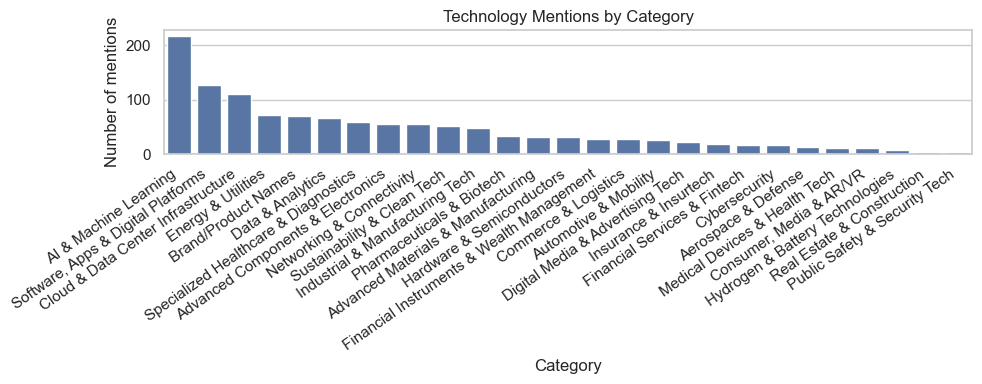

Category frequency table:


,category,count
0,AI & Machine Learning,216
1,"Software, Apps & Digital Platforms",127
2,Cloud & Data Center Infrastructure,110
3,Energy & Utilities,71
4,Brand/Product Names,70
5,Data & Analytics,67
6,Specialized Healthcare & Diagnostics,58
7,Advanced Components & Electronics,56
8,Networking & Connectivity,56
9,Sustainability & Clean Tech,52


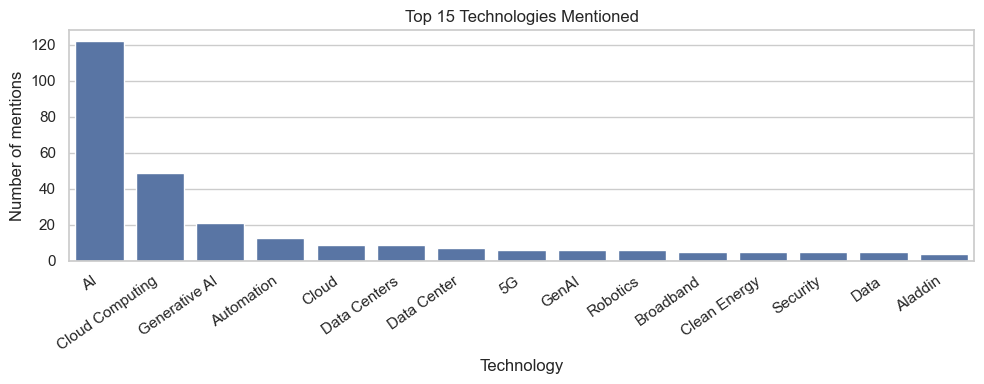

Top 15 technologies:


,technology_name,count
0,AI,122
1,Cloud Computing,49
2,Generative AI,21
3,Automation,13
4,Cloud,9
5,Data Centers,9
6,Data Center,7
7,5G,6
8,GenAI,6
9,Robotics,6


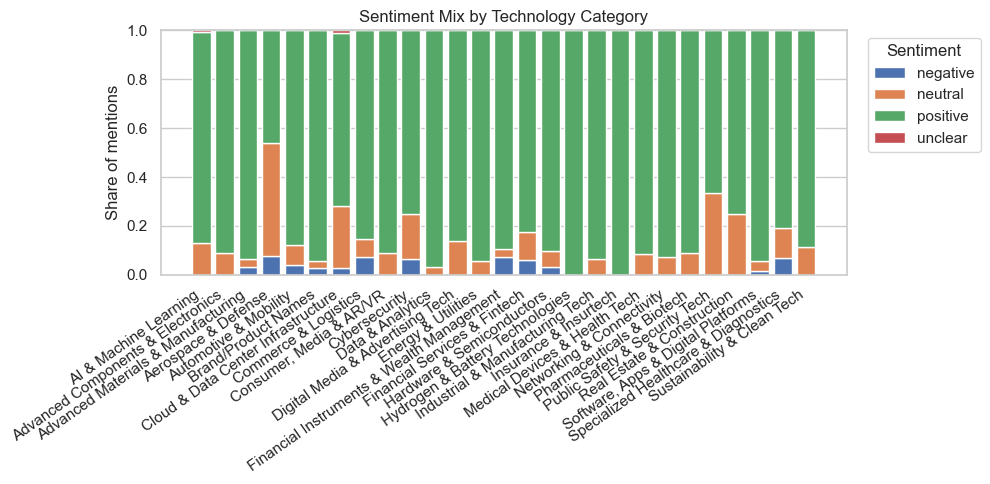

Sentiment x Category (counts):


technology_sentiment,negative,neutral,positive,unclear
category,,,,
AI & Machine Learning,0.0,28.0,187.0,1.0
Advanced Components & Electronics,0.0,5.0,51.0,0.0
Advanced Materials & Manufacturing,1.0,1.0,29.0,0.0
Aerospace & Defense,1.0,6.0,6.0,0.0
Automotive & Mobility,1.0,2.0,22.0,0.0
Brand/Product Names,2.0,2.0,66.0,0.0
Cloud & Data Center Infrastructure,3.0,28.0,78.0,1.0
Commerce & Logistics,2.0,2.0,23.0,0.0
"Consumer, Media & AR/VR",0.0,1.0,10.0,0.0


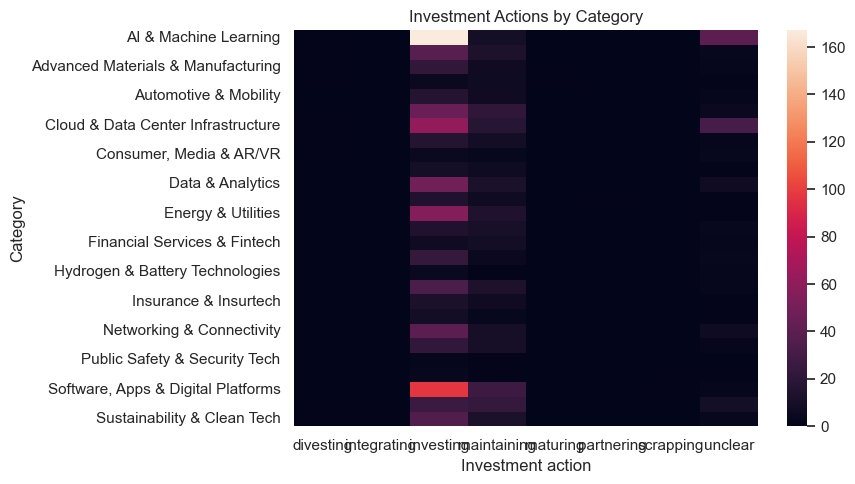

Investment actions by category (counts):


investment_action,divesting,integrating,investing,maintaining,maturing,partnering,scrapping,unclear
category,,,,,,,,
AI & Machine Learning,0,0,167,9,0,0,0,40
Advanced Components & Electronics,1,0,39,13,0,0,0,3
Advanced Materials & Manufacturing,0,0,22,7,0,0,0,2
Aerospace & Defense,1,0,4,6,1,0,0,1
Automotive & Mobility,0,0,16,7,0,0,0,2
Brand/Product Names,0,0,45,21,0,0,0,4
Cloud & Data Center Infrastructure,1,0,61,17,0,0,0,31
Commerce & Logistics,1,0,16,8,0,0,0,2
"Consumer, Media & AR/VR",0,0,5,3,0,0,0,3


Profit outlook by category (top 30 rows):


,category,profit_outlook,count
0,AI & Machine Learning,high potential,153
2,AI & Machine Learning,unclear,58
1,AI & Machine Learning,moderate potential,5
3,Advanced Components & Electronics,high potential,35
5,Advanced Components & Electronics,unclear,12
4,Advanced Components & Electronics,moderate potential,9
6,Advanced Materials & Manufacturing,high potential,16
9,Advanced Materials & Manufacturing,unclear,10
8,Advanced Materials & Manufacturing,moderate potential,4
7,Advanced Materials & Manufacturing,low potential,1


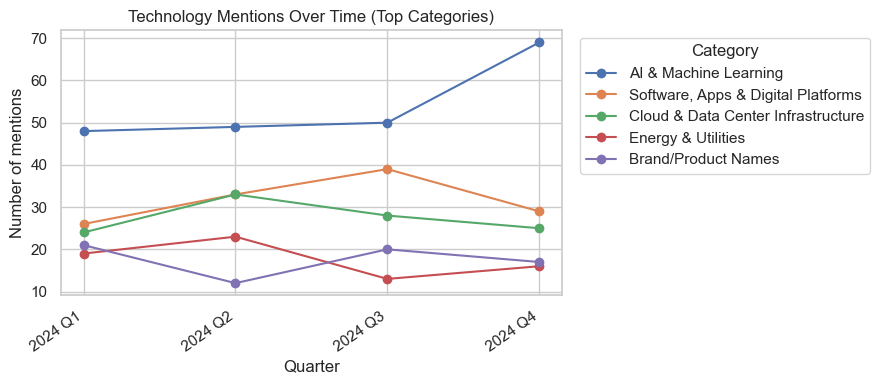

Timeline (sample):


,year,quarter,category,count,period
0,2024,1,AI & Machine Learning,48,2024 Q1
1,2024,1,Advanced Components & Electronics,21,2024 Q1
2,2024,1,Advanced Materials & Manufacturing,6,2024 Q1
3,2024,1,Aerospace & Defense,4,2024 Q1
4,2024,1,Automotive & Mobility,5,2024 Q1
5,2024,1,Brand/Product Names,21,2024 Q1
6,2024,1,Cloud & Data Center Infrastructure,24,2024 Q1
7,2024,1,Commerce & Logistics,5,2024 Q1
8,2024,1,"Consumer, Media & AR/VR",2,2024 Q1
9,2024,1,Cybersecurity,5,2024 Q1


In [33]:
# ============================================================
# BEAUTIFIED EDA: TECHNOLOGY THEMES ACROSS EARNINGS CALLS
# ============================================================
 
import seaborn as sns
import matplotlib.pyplot as plt
 
sns.set_theme(style="whitegrid")
 
# ------------------------------------------------------------
# 1. Apply catalog classifier and build clean tech_df
# ------------------------------------------------------------
eda_df["category"] = eda_df["technology_name"].apply(
    lambda x: classify_technology(x) if pd.notna(x) else None
)
 
tech_df = eda_df.dropna(subset=["technology_name"]).copy()

 
# keep a copy including Other / N.A. for coverage stats, but
# drop it for most visualisations so plots are not polluted
tech_df_clean = tech_df[tech_df["category"] != "Other / N/A"].copy()
 
print("🧾 Basic dataset overview")
print(f"- Rows in eda_df: {len(eda_df):,}")
print(f"- Technology mentions: {len(tech_df):,}")
print(f"- Classified technology mentions (excluding 'Other / N.A.'): {len(tech_df_clean):,}")
print(f"- Unique technologies: {tech_df['technology_name'].nunique():,}")
print(f"- Unique categories (excl. Other / N.A.): {tech_df_clean['category'].nunique():,}")
print(f"- Companies: {tech_df_clean['company'].nunique():,}\n")
 
# ------------------------------------------------------------
# 2. Category distribution (who talks about what)
# ------------------------------------------------------------
cat_freq = (
    tech_df_clean["category"]
    .value_counts()
    .rename_axis("category")
    .reset_index(name="count")
)
 
plt.figure(figsize=(10, 4))
sns.barplot(
    data=cat_freq,
    x="category",
    y="count"
)
plt.title("Technology Mentions by Category")
plt.xlabel("Category")
plt.ylabel("Number of mentions")
plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.show()
 
print("Category frequency table:")
display(cat_freq)
 
# ------------------------------------------------------------
# 3. Top technologies overall
# ------------------------------------------------------------
top_tech = (
    tech_df_clean["technology_name"]
    .value_counts()
    .head(15)
    .rename_axis("technology_name")
    .reset_index(name="count")
)
 
plt.figure(figsize=(10, 4))
sns.barplot(
    data=top_tech,
    x="technology_name",
    y="count"
)
plt.title("Top 15 Technologies Mentioned")
plt.xlabel("Technology")
plt.ylabel("Number of mentions")
plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.show()
 
print("Top 15 technologies:")
display(top_tech)
 
# ------------------------------------------------------------
# 4. Sentiment by category (stacked normalised bar)
# ------------------------------------------------------------
sent_df = tech_df_clean.copy()
sent_df["technology_sentiment"] = sent_df["technology_sentiment"].fillna("unspecified")
 
sent_pivot = (
    sent_df
    .groupby(["category", "technology_sentiment"])
    .size()
    .rename("count")
    .reset_index()
)
 
# normalise within category
sent_pivot["total"] = sent_pivot.groupby("category")["count"].transform("sum")
sent_pivot["share"] = sent_pivot["count"] / sent_pivot["total"]
 
sent_pivot_sorted = sent_pivot.pivot(
    index="category", columns="technology_sentiment", values="share"
).fillna(0)
 
plt.figure(figsize=(10, 5))
bottom = None
for sentiment in sent_pivot_sorted.columns:
    vals = sent_pivot_sorted[sentiment]
    plt.bar(
        sent_pivot_sorted.index,
        vals,
        bottom=bottom,
        label=sentiment
    )
    bottom = vals if bottom is None else bottom + vals
 
plt.title("Sentiment Mix by Technology Category")
plt.ylabel("Share of mentions")
plt.xticks(rotation=35, ha="right")
plt.legend(title="Sentiment", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()
 
print("Sentiment x Category (counts):")
display(
    sent_pivot
    .pivot_table(index="category", columns="technology_sentiment", values="count", fill_value=0)
)
 
# ------------------------------------------------------------
# 5. Investment action by category (heatmap)
# ------------------------------------------------------------
inv_df = tech_df_clean.copy()
inv_df["investment_action"] = inv_df["investment_action"].fillna("unspecified")
 
inv_pivot = (
    inv_df
    .groupby(["category", "investment_action"])
    .size()
    .unstack(fill_value=0)
)
 
plt.figure(figsize=(9, 5))
sns.heatmap(inv_pivot, annot=False)
plt.title("Investment Actions by Category")
plt.xlabel("Investment action")
plt.ylabel("Category")
plt.tight_layout()
plt.show()
 
print("Investment actions by category (counts):")
display(inv_pivot)
 
# ------------------------------------------------------------
# 6. Profit outlook by category (table + bar)
# ------------------------------------------------------------
profit_df = tech_df_clean.copy()
profit_df["profit_outlook"] = profit_df["profit_outlook"].fillna("unspecified")
 
profit_pivot = (
    profit_df
    .groupby(["category", "profit_outlook"])
    .size()
    .rename("count")
    .reset_index()
)
 
print("Profit outlook by category (top 30 rows):")
display(
    profit_pivot
    .sort_values(["category", "count"], ascending=[True, False])
    .head(30)
)
 
# Optional: show positive vs negative counts only
profit_simple = profit_pivot[
    profit_pivot["profit_outlook"].isin(["positive", "negative"])
].pivot(index="category", columns="profit_outlook", values="count").fillna(0)
 
if not profit_simple.empty:
    profit_simple.plot(kind="bar", figsize=(9, 4))
    plt.title("Positive vs Negative Profit Outlook by Category")
    plt.xlabel("Category")
    plt.ylabel("Number of mentions")
    plt.xticks(rotation=35, ha="right")
    plt.tight_layout()
    plt.show()
 
# ------------------------------------------------------------
# 7. Timeline by category (only top N categories)
# ------------------------------------------------------------
timeline_df = (
    tech_df_clean
    .dropna(subset=["year", "quarter"])
    .copy()
)
 
timeline = (
    timeline_df
    .groupby(["year", "quarter", "category"])
    .size()
    .rename("count")
    .reset_index()
)
 
# create "year-quarter" label
timeline["period"] = timeline["year"].astype(str) + " Q" + timeline["quarter"].astype(str)
 
# focus on top 5 categories by total mentions for readability
top_cats = cat_freq["category"].head(5).tolist()
timeline_top = timeline[timeline["category"].isin(top_cats)]
 
plt.figure(figsize=(9, 4))
for cat in top_cats:
    sub = timeline_top[timeline_top["category"] == cat]
    if not sub.empty:
        plt.plot(sub["period"], sub["count"], marker="o", label=cat)
 
plt.title("Technology Mentions Over Time (Top Categories)")
plt.xlabel("Quarter")
plt.ylabel("Number of mentions")
plt.xticks(rotation=35, ha="right")
plt.legend(title="Category", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()
 
print("Timeline (sample):")
display(timeline.head(20))

In [34]:
# --- Co-occurrence Matrix of Technologies (same company-quarter) ---
pair_df = tech_df.dropna(subset=["technology_name"])
grouped = (pair_df.groupby(["company","year","quarter"])
                 .agg(list_of=("technology_name", list))
                 .reset_index())

from collections import Counter
pairs_counter = Counter()
for _, row in grouped.iterrows():
    techs = sorted(set(row.list_of))
    for i in range(len(techs)):
        for j in range(i+1, len(techs)):
            pairs_counter[(techs[i], techs[j])] += 1

co_rows = [{"tech_a": a, "tech_b": b, "count": c} for (a,b), c in pairs_counter.items()]
co_df = pd.DataFrame(co_rows).sort_values("count", ascending=False)
print("Co-occurrence top:")
print(co_df.head(15))

Co-occurrence top:
                 tech_a             tech_b  count
60                   AI    Cloud Computing     41
619                  AI      Generative AI      7
596                  AI              GenAI      5
629                  AI      generative AI      4
2091                 AI  Electric Vehicles      4
2055              Cloud      Generative AI      4
1677                 AI                IoT      4
2052                 AI              Cloud      4
620     Cloud Computing      Generative AI      4
2154                 AI         Automation      4
1003                 AI                GPU      4
1412                 AI           Robotics      4
593                  AI               Data      4
2122  Electric Vehicles                IoT      3
2157                 AI       Clean Energy      3


In [ ]:
# --- Enhanced Knowledge Graph Construction (NetworkX) ---
import networkx as nx

G = nx.Graph()

# Add company, technology, category nodes (types)
for company in eda_df["company"].dropna().unique():
    G.add_node(f"COMPANY::{company}", type="company")

for tech in tech_df_clean["technology_name"].unique():
    if pd.isna(tech):
        continue
    G.add_node(f"TECH::{tech}", type="technology")

for cat in tech_df_clean["category"].dropna().unique():
    G.add_node(f"CAT::{cat}", type="category")

# Helper to merge node attributes into sets/lists to keep history
def _merge_attr(node_dict, key, val):
    if val is None or (isinstance(val, float) and pd.isna(val)):
        return
    if key not in node_dict:
        node_dict[key] = val
    else:
        # keep unique values as list
        cur = node_dict[key]
        if isinstance(cur, list):
            if val not in cur:
                cur.append(val)
        else:
            if val != cur:
                node_dict[key] = [cur, val]

# Edges: company -> technology (appearance) with richer attributes and weights
for _, r in tech_df.iterrows():
    if pd.isna(r.technology_name):
        continue
    cnode = f"COMPANY::{r.company}"
    tnode = f"TECH::{r.technology_name}"
    catnode = f"CAT::{r.category}" if pd.notna(r.category) else None

    # Build edge payload for this mention
    edge_payload = {
        "relation": "mentions",
        "year": int(r.year) if pd.notna(r.year) else None,
        "quarter": int(r.quarter) if pd.notna(r.quarter) else None,
        "mentioned_by": r.get("mentioned_by") or r.get("exec_name"),
        "technology_sentiment": r.get("technology_sentiment"),
        "investment_action": r.get("investment_action"),
        "investment_horizon": r.get("investment_horizon"),
        "profit_outlook": r.get("profit_outlook"),
        "rd_investment": r.get("rd_investment"),
        "revenue_impact": r.get("revenue_impact"),
    }

    # If edge already exists, update weight and append non-duplicate metadata
    if G.has_edge(cnode, tnode):
        G[cnode][tnode]["weight"] = G[cnode][tnode].get("weight", 1) + 1

        # robustly maintain lists of years/quarters (handle pre-existing non-list values)
        def _ensure_list_and_append(d, key, val):
            if val is None or (isinstance(val, float) and pd.isna(val)):
                return
            existing = d.get(key)
            if existing is None:
                d[key] = [val]
            elif isinstance(existing, list):
                existing.append(val)
            else:
                # convert single value to list if different
                if existing != val:
                    d[key] = [existing, val]

        _ensure_list_and_append(G[cnode][tnode], "years", edge_payload.get("year"))
        _ensure_list_and_append(G[cnode][tnode], "quarters", edge_payload.get("quarter"))

        # merge other fields into lists (avoid duplicates), handling non-list existing values
        for k in ["mentioned_by", "technology_sentiment", "investment_action", "investment_horizon",
                  "profit_outlook", "rd_investment", "revenue_impact"]:
            v = edge_payload.get(k)
            if v is not None and not (isinstance(v, float) and pd.isna(v)):
                existing = G[cnode][tnode].get(k)
                if existing is None:
                    G[cnode][tnode][k] = [v]
                elif isinstance(existing, list):
                    if v not in existing:
                        existing.append(v)
                else:
                    # existing is a scalar -> convert to list if different
                    if existing != v:
                        G[cnode][tnode][k] = [existing, v]
    else:
        # initial edge
        payload = {k: v for k, v in edge_payload.items() if v is not None and not (isinstance(v, float) and pd.isna(v))}
        payload["weight"] = 1
        payload["years"] = [payload.pop("year", None)]
        payload["quarters"] = [payload.pop("quarter", None)]
        G.add_edge(cnode, tnode, **payload)

    # Technology -> Category edge
    if catnode:
        if not G.has_edge(tnode, catnode):
            G.add_edge(tnode, catnode, relation="classified_as")
        # also attach category attribute on the tech node
        node_attrs = G.nodes[tnode]
        _merge_attr(node_attrs, "categories", r.get("category"))

    # Attach/merge tech-level attributes onto technology node (keeps history)
    t_attrs = G.nodes[tnode]
    for k in ["technology_sentiment", "investment_action", "investment_horizon",
              "profit_outlook", "rd_investment", "revenue_impact", "mentioned_by"]:
        _merge_attr(t_attrs, k, r.get(k))

print("Graph nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())

# Export (GraphML) for external visualization
# GraphML does not support list / complex types as attribute values.
# Create a GraphML-safe copy where lists/arrays/dicts are serialized to strings.
import json
import numpy as np

def _serialize_value(v):
    # drop NA-like values
    if v is None or (isinstance(v, float) and pd.isna(v)):
        return None
    # numpy arrays -> list -> join
    if isinstance(v, np.ndarray):
        return ';'.join(str(x) for x in v.tolist())
    # iterable containers -> join
    if isinstance(v, (list, tuple, set)):
        return ';'.join(str(x) for x in v)
    # dicts -> json string
    if isinstance(v, dict):
        return json.dumps(v, default=str)
    # fallback scalar -> string
    return str(v)

H = nx.Graph()
# copy nodes with serialized attributes
for n, attrs in G.nodes(data=True):
    new_attrs = {}
    for k, val in attrs.items():
        sv = _serialize_value(val)
        if sv is not None:
            new_attrs[k] = sv
    H.add_node(n, **new_attrs)

# copy edges with serialized attributes
for u, v, attrs in G.edges(data=True):
    new_attrs = {}
    for k, val in attrs.items():
        sv = _serialize_value(val)
        if sv is not None:
            new_attrs[k] = sv
    H.add_edge(u, v, **new_attrs)

nx.write_graphml(H, "technology_graph_enhanced.graphml")
print("GraphML written: technology_graph_enhanced.graphml (serialized list/complex attributes)")


Graph nodes: 1510 edges: 3005
GraphML written: technology_graph_enhanced.graphml (serialized list/complex attributes)


In [ ]:
# --- Interactive Knowledge Graph using Pyvis (enriched tooltips, sizes, and styles) ---
from pyvis.network import Network
import math

# Build size map for technology nodes by frequency
_tech_count_map = tech_df_clean.groupby("technology_name").size().to_dict()

def _safe_join(v):
    if v is None:
        return ""
    if isinstance(v, (list, set, tuple)):
        vals = [str(x) for x in v if x is not None and str(x).strip() != ""]
        # de-duplicate while preserving order
        seen = set()
        uniq = []
        for x in vals:
            if x not in seen:
                uniq.append(x)
                seen.add(x)
        return ", ".join(uniq) if uniq else ""
    return str(v)

# Create a Pyvis network
net = Network(
    notebook=True,       #
    directed=False,
    height="800px",
    width="100%",
    bgcolor="#ffffff",
    font_color="black"
)

# Physics options (stable layout)
net.barnes_hut(
    gravity=-500,
    central_gravity=0.1,
    spring_length=200,
    spring_strength=0.01,
    damping=0.95
)

# Define colors for node types and sentiments
colors = {
    "company": "#ff6666",     # red-ish
    "technology": "#66b3ff",  # blue-ish
    "category": "#99e699"     # green-ish
}
sent_colors = {
    "positive": "#2ecc71",
    "neutral": "#95a5a6",
    "negative": "#e74c3c"
}

# Add nodes with colors based on their type, and rich titles
for node, data in G.nodes(data=True):
    ntype = data.get("type", "unknown")
    color = colors.get(ntype, "#cccccc")
    label = node.replace("COMPANY::", "").replace("TECH::", "").replace("CAT::", "")
    title_lines = [f"Type: {ntype}"]
    # Attach summary attributes for technology nodes
    if ntype == "technology":
        # aggregated fields were merged into lists in G-building cell
        cats = data.get("categories")
        if cats:
            title_lines.append(f"Categories: {_safe_join(cats)}")
        for k in ["technology_sentiment", "investment_action", "investment_horizon",
                  "profit_outlook", "rd_investment", "revenue_impact", "mentioned_by"]:
            v = data.get(k)
            if v:
                title_lines.append(f"{k}: {_safe_join(v)}")
        # size by frequency
        tcount = _tech_count_map.get(label, 1)
        size = max(10, min(40, 10 + int(3 * math.sqrt(tcount))))
    else:
        size = 18 if ntype == "category" else 16

    net.add_node(node, label=label, color=color, title="<br>".join(title_lines), size=size)

# Add edges with relation info, weight, time (years/quarters), and attributes
# Ensure any node referenced by an edge exists in the pyvis network.
# If a node is missing (e.g. stray sentiment strings like 'neutral'), add a small placeholder node.
existing_ids = set(nd.get("id") for nd in net.nodes)

for u, v, data in G.edges(data=True):
    # auto-add missing nodes to avoid pyvis/networkx assertion errors
    for n in (u, v):
        if n not in existing_ids:
            # create a reasonable label and color for the auto node
            lab = str(n).replace("COMPANY::", "").replace("TECH::", "").replace("CAT::", "")
            if isinstance(n, str) and n.startswith("COMPANY::"):
                ntype = "company"
            elif isinstance(n, str) and n.startswith("TECH::"):
                ntype = "technology"
            elif isinstance(n, str) and n.startswith("CAT::"):
                ntype = "category"
            elif isinstance(n, str) and str(n).lower() in sent_colors:
                ntype = "sentiment"
            else:
                ntype = "unknown"

            # color fallback: use type colors, then sentiment colors, then grey
            color = colors.get(ntype, sent_colors.get(str(n).lower(), "#cccccc"))
            size = 10 if ntype == "technology" else 12 if ntype == "category" else 8

            net.add_node(n, label=lab, color=color, title=f"Auto-added node ({ntype})", size=size)
            existing_ids.add(n)

    rel = data.get("relation", "")
    w = int(data.get("weight", 1))
    years = data.get("years")
    quarters = data.get("quarters")
    # edge coloring by (first) sentiment if present
    esent = data.get("technology_sentiment")
    if isinstance(esent, list) and len(esent) > 0:
        esent_show = esent[0]
    else:
        esent_show = esent if isinstance(esent, str) else None
    ecolor = sent_colors.get(str(esent_show).lower(), "#999999") if esent_show else "#999999"

    # collect other edge attributes (aggregated lists)
    extra_parts = []
    for k in ["mentioned_by", "investment_action", "investment_horizon",
              "profit_outlook", "rd_investment", "revenue_impact", "technology_sentiment"]:
        vv = data.get(k)
        if vv:
            extra_parts.append(f"{k}: {_safe_join(vv)}")

    time_part = ""
    if years or quarters:
        ytxt = _safe_join(sorted(set(years))) if years else ""
        qtxt = _safe_join(quarters) if quarters else ""
        time_part = f"<br>Years: {ytxt} Qtrs: {qtxt}"

    title = f"Relation: {rel}<br>Weight: {w}{time_part}"
    if extra_parts:
        title += "<br>" + "<br>".join(extra_parts)

    # edge width by weight
    width = max(1, min(6, w))
    net.add_edge(u, v, title=title, color=ecolor, width=width)

# Export to HTML
output_file = "knowledge_graph.html"
net.show(output_file)
print(f"✅ Interactive graph saved to {output_file}. Open it in a browser to explore.")

knowledge_graph.html
✅ Interactive graph saved to knowledge_graph.html. Open it in a browser to explore.


Subgraph nodes: 110 edges: 203


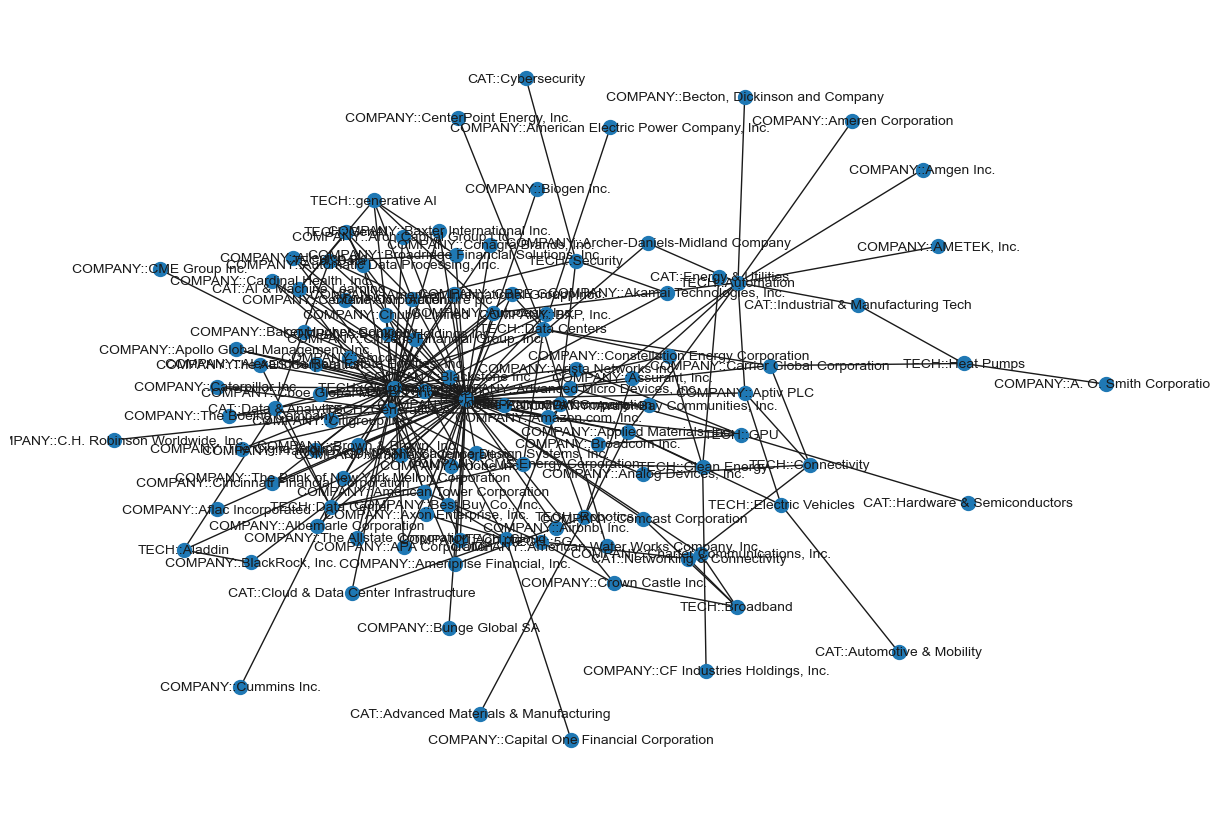

In [37]:
# --- Subgraph with the top 20 technologies by frequency ---
import matplotlib.pyplot as plt
 
# FIX: Create tech_freq properly
tech_freq = (
    tech_df_clean.groupby("technology_name")
           .size()
           .sort_values(ascending=False)
           .rename("count")
           .reset_index()
)
 
# Now tech_freq exists and we can safely access technology_name
top_techs = tech_freq.head(20)["technology_name"].tolist()
 
subgraph_nodes = set()
 
for tech in top_techs:
    tnode = f"TECH::{tech}"
    if tnode in G:
        subgraph_nodes.add(tnode)
        for neighbor in G.neighbors(tnode):
            subgraph_nodes.add(neighbor)
 
subG = G.subgraph(subgraph_nodes)
 
print("Subgraph nodes:", subG.number_of_nodes(), "edges:", subG.number_of_edges())
 
# --- Visualize the subgraph ---
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subG, k=0.15, iterations=20)
nx.draw(subG, pos, with_labels=True, node_size=100, font_size=10)
plt.show()

In [38]:
# --- Pyvis for top-20 technologies subgraph (enriched tooltips, sizes, styles) ---
from pyvis.network import Network
from IPython.display import IFrame, display
import os
import math

# Build size map for technology nodes by frequency
_tech_count_map = tech_df_clean.groupby("technology_name").size().to_dict()

def _safe_join(v):
    if v is None:
        return ""
    if isinstance(v, (list, set, tuple)):
        vals = [str(x) for x in v if x is not None and str(x).strip() != ""]
        seen = set()
        uniq = []
        for x in vals:
            if x not in seen:
                uniq.append(x)
                seen.add(x)
        return ", ".join(uniq) if uniq else ""
    return str(v)

# Use top 20 by frequency (you can filter to "investing" if desired)
top_techs = tech_freq.head(20)["technology_name"].tolist()
# Example: uncomment to restrict to techs that have 'investing' action somewhere in the graph
# top_techs = [t for t in top_techs if "TECH::"+t in G and "investment_action" in G.nodes["TECH::"+t]
#              and any(isinstance(x, str) and x.lower()=="investing" for x in (G.nodes["TECH::"+t]["investment_action"] if isinstance(G.nodes["TECH::"+t]["investment_action"], list) else [G.nodes["TECH::"+t]["investment_action"]]))]

# Collect nodes: companies, categories, and top technologies
subgraph_nodes = set()
for tech in top_techs:
    tnode = f"TECH::{tech}"
    if tnode not in G:
        continue
    subgraph_nodes.add(tnode)
    # neighbors in original graph (likely companies and categories)
    for neighbor in G.neighbors(tnode):
        subgraph_nodes.add(neighbor)

# Create subgraph
subG = G.subgraph(subgraph_nodes).copy()
print("Subgraph nodes:", subG.number_of_nodes(), "edges:", subG.number_of_edges())

# Create the Pyvis network
net = Network(
    notebook=True,
    directed=False,
    height="800px",
    width="100%",
    bgcolor="#ffffff",
    font_color="black"
)

# Physics tuning for smaller, stable layout
net.barnes_hut(
    gravity=-800,
    central_gravity=0.2,
    spring_length=150,
    spring_strength=0.03,
    damping=0.9
)

# Node colors and edge sentiment colors
colors = {
    "company": "#ff6666",
    "technology": "#66b3ff",
    "category": "#99e699"
}
sent_colors = {
    "positive": "#2ecc71",
    "neutral": "#95a5a6",
    "negative": "#e74c3c"
}

# Add nodes with labels and tooltips
for node, data in subG.nodes(data=True):
    ntype = data.get("type", "unknown")
    color = colors.get(ntype, "#cccccc")
    label = node
    if label.startswith("COMPANY::"):
        label = label.replace("COMPANY::", "")
    elif label.startswith("TECH::"):
        label = label.replace("TECH::", "")
    elif label.startswith("CAT::"):
        label = label.replace("CAT::", "")
    title = [f"Type: {ntype}"]
    if ntype == "technology":
        cats = data.get("categories")
        if cats:
            title.append(f"Categories: {_safe_join(cats)}")
        for k in ["technology_sentiment", "investment_action", "investment_horizon",
                  "profit_outlook", "rd_investment", "revenue_impact", "mentioned_by"]:
            v = data.get(k)
            if v:
                title.append(f"{k}: {_safe_join(v)}")
        tcount = _tech_count_map.get(label, 1)
        size = max(12, min(42, 10 + int(3 * math.sqrt(tcount))))
    else:
        size = 22 if ntype == "category" else 18

    net.add_node(node, label=label, color=color, title="<br>".join(title), size=size)

# Add edges with tooltips and styling
for u, v, data in subG.edges(data=True):
    rel = data.get("relation", "")
    w = int(data.get("weight", 1))
    years = data.get("years")
    quarters = data.get("quarters")
    esent = data.get("technology_sentiment")
    if isinstance(esent, list) and len(esent) > 0:
        esent_show = esent[0]
    else:
        esent_show = esent if isinstance(esent, str) else None
    ecolor = sent_colors.get(str(esent_show).lower(), "#999999") if esent_show else "#999999"

    parts = [f"Relation: {rel}" if rel else ""]
    parts.append(f"Weight: {w}")
    if years or quarters:
        ytxt = _safe_join(sorted(set(years))) if years else ""
        qtxt = _safe_join(quarters) if quarters else ""
        parts.append(f"Years: {ytxt} Qtrs: {qtxt}")
    for k in ["mentioned_by", "investment_action", "investment_horizon",
              "profit_outlook", "rd_investment", "revenue_impact", "technology_sentiment"]:
        aval = data.get(k)
        if aval:
            parts.append(f"{k}: {_safe_join(aval)}")
    title = "<br>".join([p for p in parts if p])

    width = max(1, min(6, w))
    net.add_edge(u, v, title=title, color=ecolor, width=width)

# Output filename
output_file = "top_techs_subgraph.html"
net.show(output_file)

# Embed inline in notebook
if os.path.exists(output_file):
    display(IFrame(src=output_file, width="100%", height="800px"))
else:
    print(f"Error: {output_file} not found.")

Subgraph nodes: 110 edges: 203
top_techs_subgraph.html


In [39]:
# --- Query Helpers ---
def top_technologies(n=20):
    return tech_freq.head(n)

def technologies_in_category(cat):
    return tech_df.loc[tech_df.category==cat,"technology_name"].unique()

def company_techs(company):
    return tech_df.loc[tech_df.company==company, ["technology_name","category","technology_sentiment"]]

def category_timeline(cat):
    return timeline.loc[timeline.category==cat].sort_values(["year","quarter"])

print(top_technologies(10))
print(technologies_in_category("Cloud, AI & Software")[:15])
print(company_techs("The Clorox Company").head())

   technology_name  count
0               AI    122
1  Cloud Computing     49
2    Generative AI     21
3       Automation     13
4     Data Centers      9
5            Cloud      9
6      Data Center      7
7         Robotics      6
8               5G      6
9            GenAI      6
[]
             technology_name                            category  \
3164           Cybersecurity                       Cybersecurity   
3165       IT infrastructure  Cloud & Data Center Infrastructure   
3169             Cyberattack                         Other / N/A   
3173  Digital transformation  Software, Apps & Digital Platforms   
3177   cyber-attack recovery                         Other / N/A   

     technology_sentiment  
3164             negative  
3165              neutral  
3169             negative  
3173             positive  
3177              neutral  


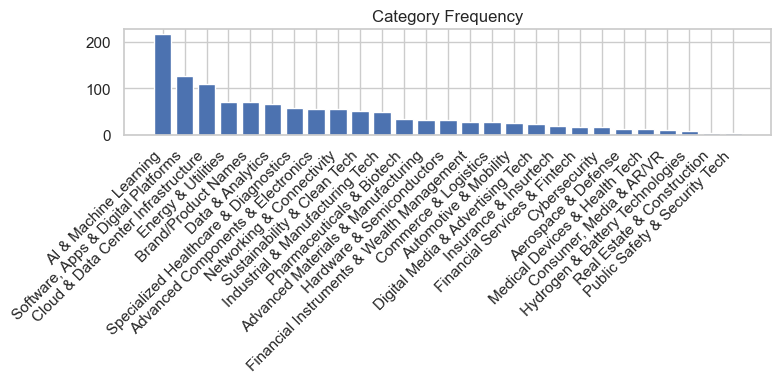

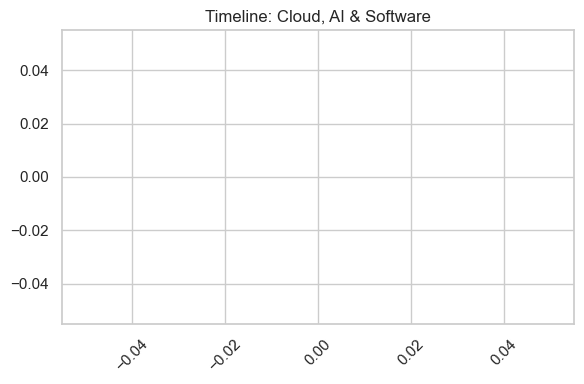

In [40]:
# --- Simple Visualization (optional) ---
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.bar(cat_freq.category, cat_freq["count"])
plt.xticks(rotation=45, ha="right")
plt.title("Category Frequency")
plt.tight_layout()
plt.show()

# Timeline plot example for one category
cat_example = "Cloud, AI & Software"
tl = category_timeline(cat_example)
plt.figure(figsize=(6,4))
plt.plot(tl["year"].astype(str)+"Q"+tl["quarter"].astype(str), tl["count"], marker="o")
plt.title(f"Timeline: {cat_example}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [41]:
# --- Pyvis subgraph: Company -> Category -> Technology ---
from pyvis.network import Network
from IPython.display import IFrame, display
import os
import networkx as nx

# --- 1. Create a subgraph for top 20 technologies ---
top_techs = tech_freq.head(20)["technology_name"].tolist()

# Collect nodes: companies, categories, and top technologies
subgraph_nodes = set()
for tech in top_techs:
    tnode = f"TECH::{tech}"
    subgraph_nodes.add(tnode)
    # neighbors in original graph (likely companies and categories)
    for neighbor in G.neighbors(tnode):
        subgraph_nodes.add(neighbor)

# Create subgraph
subG = G.subgraph(subgraph_nodes).copy()
print("Subgraph nodes:", subG.number_of_nodes(), "edges:", subG.number_of_edges())

# --- 2. Create a Pyvis network ---
net = Network(
    notebook=True,
    directed=True,      # directed: Company -> Category -> Technology
    height="800px",
    width="100%",
    bgcolor="#ffffff",
    font_color="black"
)

# Physics tuning for smaller, stable layout
net.barnes_hut(
    gravity=-800,
    central_gravity=0.2,
    spring_length=150,
    spring_strength=0.03,
    damping=0.9
)

# Node colors
colors = {
    "company": "#ff6666",     # red
    "category": "#99e699",    # green
    "technology": "#66b3ff"   # blue
}

# Add nodes with labels and tooltips
for node, data in subG.nodes(data=True):
    ntype = data.get("type", "unknown")
    color = colors.get(ntype, "#cccccc")
    label = node
    if label.startswith("COMPANY::"):
        label = label.replace("COMPANY::", "")
    elif label.startswith("TECH::"):
        label = label.replace("TECH::", "")
    elif label.startswith("CAT::"):
        label = label.replace("CAT::", "")
    title = f"Type: {ntype}"
    if "sentiment" in data and data["sentiment"] is not None:
        title += f"<br>Sentiment: {data['sentiment']}"
    # Make top technologies bigger to highlight them
    size = 25 if node.startswith("TECH::") else 15
    net.add_node(node, label=label, color=color, title=title, size=size)

# --- 3. Add edges: Company -> Category -> Technology ---
for tech in top_techs:
    tnode = f"TECH::{tech}"
    # link companies -> categories
    for neighbor in G.neighbors(tnode):
        ndata = G.nodes[neighbor]
        if ndata.get("type") == "company":
            # find category connected to this tech
            cat_neighbors = [n for n in G.neighbors(tnode) if G.nodes[n].get("type")=="category"]
            for cat in cat_neighbors:
                net.add_edge(neighbor, cat, title="works_in")  # Company -> Category
                net.add_edge(cat, tnode, title="includes")      # Category -> Technology

# --- 4. Show in notebook ---
output_file = "company_category_technology.html"
net.show(output_file)

if os.path.exists(output_file):
    display(IFrame(src=output_file, width="100%", height="800px"))
else:
    print(f"Error: {output_file} not found.")


Subgraph nodes: 110 edges: 203
company_category_technology.html
